# Read from the storage database

In [1]:
import numpy as np
import pandas as pd
import pymysql
import sqlalchemy as sql
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
sns.set()
import getopt
import sys
import datetime
from scipy.interpolate import interp1d
from CorrectPressure import CorrectPressure
from NGDataObject import NGDataObject

#*******************************
# CONSTANTS
#*******************************
# connection to database
CREDENTIALS_FILE = '/Users/hkromer/02_PhD/01.github/dash_NG/credentials.pw'
DB = "NG_twofast_DB" # name of the database
HOST = "twofast-RPi3-0"  # database host

# LOOKUP TABLES
LUT_PRESSURE_ION_SOURCE = "/Users/hkromer/02_PhD/01.github/phd/01_neutron_generator_contol/LUT_pressure_ion_source.txt"

# ETL settings

In [2]:
# for which day to plot
DAY = "2020-03-03" # day to extract from the db
PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-02.DetectorVisitorsAachen/'

## Load from database

In [11]:

# read password and user to connect to database
credentials = pd.read_csv(CREDENTIALS_FILE, header=0)
user = credentials['username'].values[0]
pw = credentials['password'].values[0]


#*******************************
# GET DATA
#*******************************

# connect to DB
con = NGDataObject(host = HOST, database=DB, user=user, password=pw)

# get dose
query = "SELECT * FROM data_dose WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_dose = con.get_from_database(query=query)

# get HV
query = "SELECT * FROM data_HV WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_hv = con.get_from_database(query=query)
data_hv['HV_current_x100'] = data_hv['HV_current']*100.0

# get pressure
query = "SELECT * FROM data_pressure WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_pressure = con.get_from_database(query=query)

# get reference detectors
query = "SELECT * FROM data_referenceDetectors WHERE DATE(time) > '2020-01-30 20:00:00'" 
data_reference_full = con.get_from_database(query=query)

# get microwave power
query = "SELECT * FROM microwave_generator_power WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_power_full = con.get_from_database(query=query)

# get microwave frequency
query = "SELECT * FROM microwave_generator_frequency WHERE DATE(time) = '%(t)s'" % {"t": DAY}
data_microwave_frequency_full = con.get_from_database(query=query)

# save to file
data_reference_full['sum_counts'] = data_reference_full['counts_D1'] + data_reference_full['counts_D2'] + data_reference_full['counts_D3'] + data_reference_full['counts_D4'] 

data_dose.to_csv(f'{PATH}/2020-03-03_dose.csv')
data_hv.to_csv(f'{PATH}/2020-03-03_hv.csv')
data_pressure.to_csv(f'{PATH}/2020-03-03_pressure.csv')
data_reference_full.to_csv(f'{PATH}/2020-03-03_reference_detectors.csv')
data_microwave_power_full.to_csv(f'{PATH}/2020-03-03_microwave_power.csv')
data_microwave_frequency_full.to_csv(f'{PATH}/2020-03-03_microwave_frequency.csv')

## Load from csv


In [3]:
data_dose = pd.read_csv(f'{PATH}/2020-03-03_dose.csv', index_col=0)
data_dose.index = pd.to_datetime(data_dose.index)

data_hv = pd.read_csv(f'{PATH}/2020-03-03_hv.csv', index_col=0)
data_hv.index = pd.to_datetime(data_hv.index)

data_pressure = pd.read_csv(f'{PATH}/2020-03-03_pressure.csv', index_col=0)
data_pressure.index = pd.to_datetime(data_pressure.index)

data_reference_full = pd.read_csv(f'{PATH}/2020-03-03_reference_detectors.csv', index_col=0)
data_reference_full.index = pd.to_datetime(data_reference_full.index)

data_microwave_power_full = pd.read_csv(f'{PATH}/2020-03-03_microwave_power.csv', index_col=0)
data_microwave_power_full.index = pd.to_datetime(data_microwave_power_full.index)

data_microwave_frequency_full = pd.read_csv(f'{PATH}/2020-03-03_microwave_frequency.csv', index_col=0)
data_microwave_frequency_full.index = pd.to_datetime(data_microwave_frequency_full.index)


## Correct the pressure with the display correlation

In [4]:
data_pressure.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 82113 entries, 2020-03-03 00:00:00.993705 to 2020-03-03 23:59:59.867353
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     82113 non-null  int64  
 1   pressure_IS            82113 non-null  float64
 2   pressure_VC            82113 non-null  float64
 3   voltage_IS             82113 non-null  float64
 4   voltage_VC             82113 non-null  float64
 5   pressure_IS_corrected  82113 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 4.4 MB


In [5]:
cp = CorrectPressure()
p_corr = cp.int_pol_pressure(data_pressure['pressure_IS_corrected'].values).reshape(-1)
data_pressure['pressure_IS_display_corr'] = p_corr
data_pressure.head()

,id,pressure_IS,pressure_VC,voltage_IS,voltage_VC,pressure_IS_corrected,pressure_IS_display_corr
time,,,,,,,
2020-03-03 00:00:00.993705,8977138,0.000003,4.677350e-12,3.48,0.0,0.000003,0.000003
2020-03-03 00:00:02.042534,8977139,0.000003,4.677350e-12,3.48,0.0,0.000003,0.000003
2020-03-03 00:00:03.095258,8977140,0.000003,4.677350e-12,3.48,0.0,0.000003,0.000003
2020-03-03 00:00:04.147948,8977141,0.000003,4.677350e-12,3.48,0.0,0.000003,0.000003
2020-03-03 00:00:05.196779,8977142,0.000003,4.677350e-12,3.48,0.0,0.000003,0.000003


# Plots

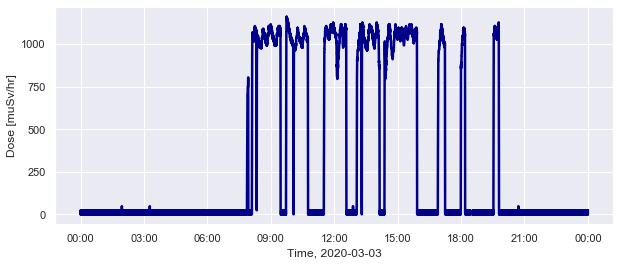

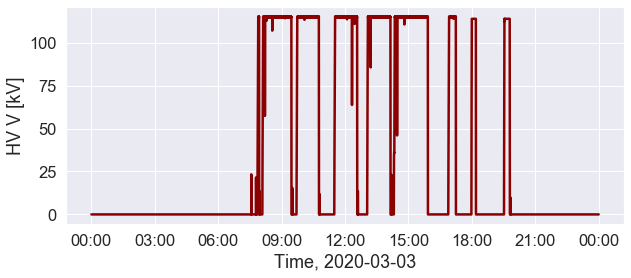

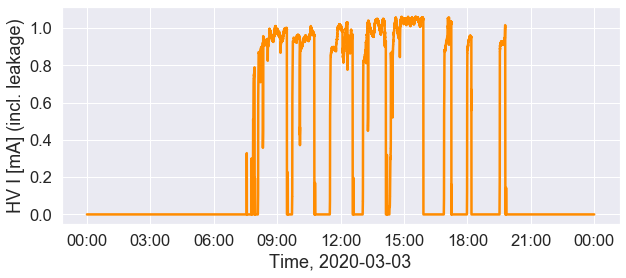

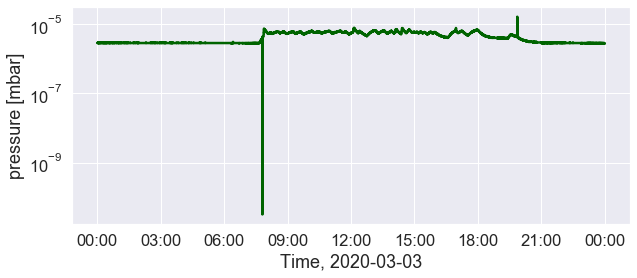

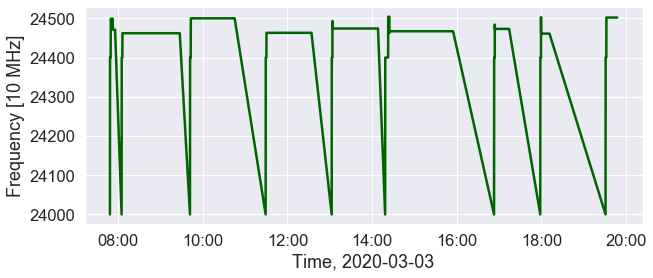

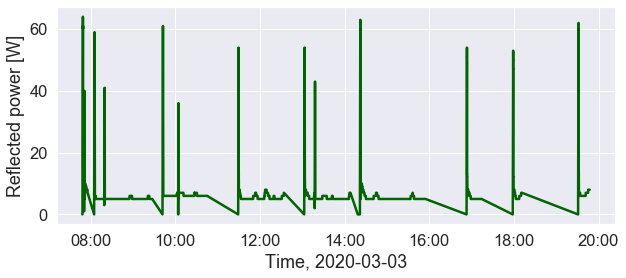

In [6]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose.index, y='dose_corrected', data=data_dose, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_voltage', data=data_hv, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_current', data=data_hv, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_pressure.index, y='pressure_IS_corrected', data=data_pressure, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('pressure [mbar]')
ax.set_xlabel(f'Time, {DAY}')
ax.set_yscale('log')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_microwave_frequency_full.index, y='frequency', data=data_microwave_frequency_full, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Frequency [10 MHz]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_microwave_power_full.index, y='RP', data=data_microwave_power_full, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Reflected power [W]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


## Select only relevant time

In [7]:
t0 = f'{DAY} 08:00:00'
t1 = f'{DAY} 20:00:00'


data_dose = data_dose.loc[t0:t1, :]
data_hv = data_hv.loc[t0:t1, :]
data_pressure = data_pressure.loc[t0:t1, :]
data_reference_full = data_reference_full.loc[t0:t1, :]
data_microwave_power_full = data_microwave_power_full.loc[t0:t1, :]
data_microwave_frequency_full = data_microwave_frequency_full.loc[t0:t1, :]

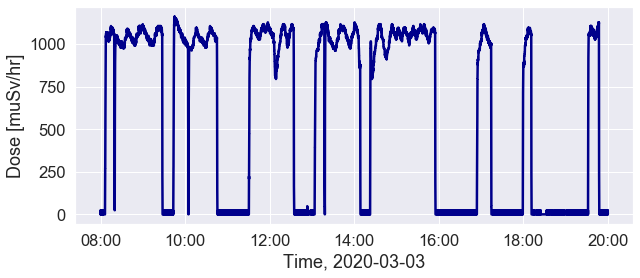

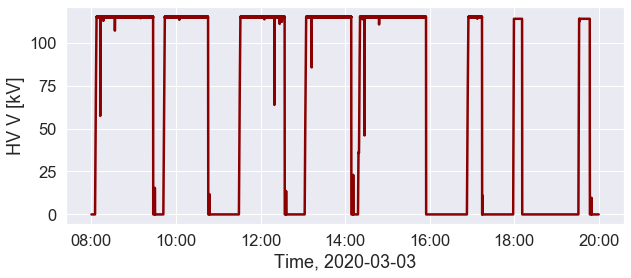

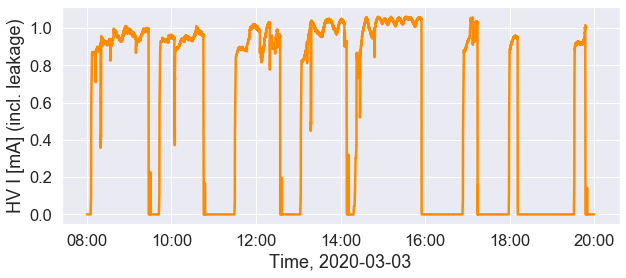

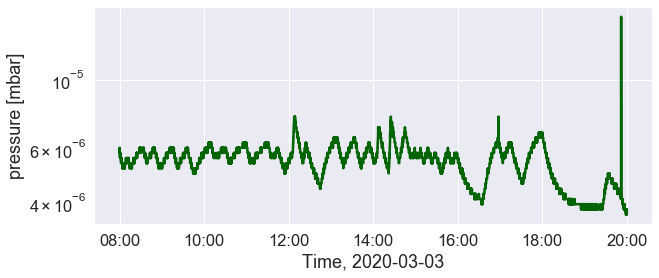

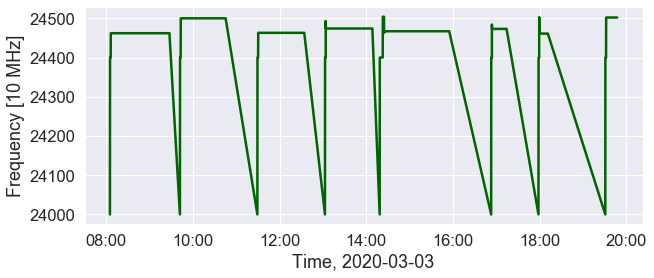

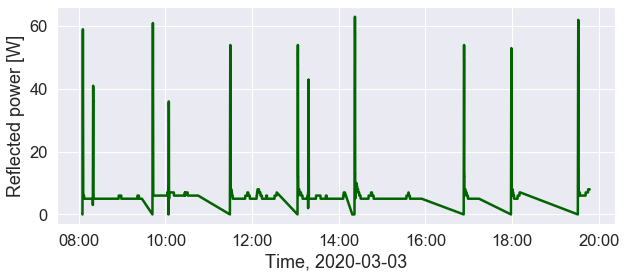

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose.index, y='dose_corrected', data=data_dose, ax=ax, color='darkblue')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_voltage', data=data_hv, ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV V [kV]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_hv.index, y='HV_current', data=data_hv, ax=ax, color='darkorange')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('HV I [mA] (incl. leakage)')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_pressure.index, y='pressure_IS_corrected', data=data_pressure, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('pressure [mbar]')
ax.set_xlabel(f'Time, {DAY}')
ax.set_yscale('log')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_microwave_frequency_full.index, y='frequency', data=data_microwave_frequency_full, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Frequency [10 MHz]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_microwave_power_full.index, y='RP', data=data_microwave_power_full, ax=ax, color='darkgreen')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Reflected power [W]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()


## Add neutron output to dose

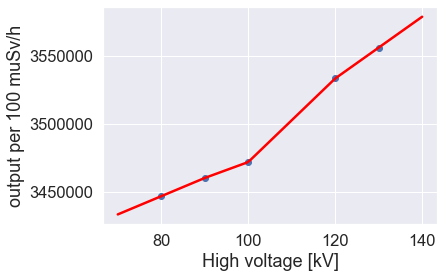

34719.54196076212

In [9]:
data_mcnp_LUT = pd.read_csv("/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-01.MCNP_2e8nps/LUT_dose_output.csv", index_col=0) # output per 100 muSv/hr
# take 100 kV
interp_dose = interp1d(data_mcnp_LUT.index, data_mcnp_LUT['E'].values, fill_value='extrapolate')
x = np.linspace(70, 140, 100, endpoint=True)
plt.plot(x, interp_dose(x), color='red')
plt.scatter(data_mcnp_LUT.index, data_mcnp_LUT['E'])
plt.xlabel('High voltage [kV]')
plt.ylabel('output per 100 muSv/h')
plt.show()

dose_to_output = data_mcnp_LUT.loc[100, 'E']


dose_to_output = dose_to_output / 100 # per 1 muSv/h
dose_to_output # output per 1 muSv/hr

In [10]:
data_dose['neutron_yield'] = data_dose['dose_corrected'].values * (interp_dose(data_dose['HV_voltage'].values) / 100)

KeyError: 'HV_voltage'

## Correct leakage current

In [ ]:
data_I_leak = pd.read_csv('/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-02-03.NeutronOutputVSBeamPower/2020-02-03_LEAKGE_CURRENT_LUT.csv', index_col=0)
# interpolate
X = data_I_leak['HV_voltage'].values.astype(np.float64)
Y = data_I_leak['HV_current'].values.astype(np.float64)
interp_leak = interp1d(X, Y, fill_value='extrapolate')
x = np.linspace(40, 160, 1000, endpoint=True)
plt.plot(x, interp_leak(x), color='red')
plt.scatter(data_I_leak['HV_voltage'], data_I_leak['HV_current'])
plt.xlabel('High voltage [kV]')
plt.ylabel('Leakage current [mA]')
plt.show()

In [ ]:
# real target current without leakage current
data_hv['HV_current_real'] = data_hv['HV_current'] - interp_leak(data_hv['HV_voltage'].values)
# data_hv.loc[f"{DAY} 13:30:00":f"{DAY} 14:00:00"]
idx = data_hv[data_hv['HV_voltage'] < 10].index
data_hv.loc[idx, 'HV_current_real'] = 0

# Resample all in 10 seconds intervals


In [ ]:
def resample_data(df, cols, range_start, range_end):
    """
    Takes the a grouped df (grouped by day) and resamples the columns cols in 10s
    OUTPUT:
        - dataframe
    """

    d = {}

    s = pd.date_range(start=range_start, end=range_end, freq='10S')
    df_out = pd.DataFrame(pd.Series(s, name='time')).set_index('time')
    for col in cols:
        d[col] = df[col].resample('10S').mean()

    this_d = pd.DataFrame(d)

    df_out = df_out.merge(this_d, left_on=df_out.index, right_on=this_d.index, how='outer')
    df_out = df_out.set_index('key_0')
    df_out.index.name ='time'    
    
    return df_out

In [ ]:
# reference detector
df_reference = resample_data(data_reference_full, ['sum_counts'], t0, t1)
df_reference.rename(columns={'sum_counts': 'reference_detector'}, inplace=True)

# microwave power
df_mw_power = resample_data(data_microwave_power_full, ['RP'], t0, t1)
df_mw_power.rename(columns={'RP': 'mw_reflected_power'}, inplace=True)

# microwave frequency
df_mw_freq = resample_data(data_microwave_frequency_full, ['frequency'], t0, t1)
df_mw_freq.rename(columns={'frequency': 'mw_frequency'}, inplace=True)
df_mw_freq['mw_frequency'] = df_mw_freq['mw_frequency'] * 0.1 

# dose
df_dose = resample_data(data_dose, ['dose_corrected', 'neutron_yield'], t0, t1)
df_dose.rename(columns={'dose_corrected': 'dose'}, inplace=True)


# high voltage and current
df_hv = resample_data(data_hv, ['HV_voltage', 'HV_current', 'HV_current_real'], t0, t1)
# df_hv.rename(columns={'dose_corrected': 'dose'}, inplace=True)

# pressure
df_pressure = resample_data(data_pressure, ['pressure_IS_display_corr'], t0, t1)
df_pressure.rename(columns={'pressure_IS_display_corr': 'pressure'}, inplace=True)


In [ ]:
data = pd.merge(df_reference, df_mw_power, left_index=True, right_index=True)
data = pd.merge(data, df_mw_freq, left_index=True, right_index=True)
data = pd.merge(data, df_dose, left_index=True, right_index=True)
data = pd.merge(data, df_hv, left_index=True, right_index=True)
data = pd.merge(data, df_pressure, left_index=True, right_index=True)
data.head()

In [ ]:
t0 = f"{DAY} 14:30:00"
t1 = f"{DAY} 16:00:00"

fig, ax = plt.subplots(figsize=(10,4))
sns.set()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data_dose.loc[t0:t1,:].index, y='dose_corrected', data=data_dose.loc[t0:t1,:], ax=ax, color='darkblue')
sns.lineplot(x=data.loc[t0:t1,:].index, y='dose', data=data.loc[t0:t1,:], ax=ax, color='darkred')

ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))
ax.set_ylabel('Dose [muSv/hr]')
ax.set_xlabel(f'Time, {DAY}')
plt.show()

In [ ]:
OUTPUT_PATH = '/Users/hkromer/02_PhD/02_Data/13.new_chamber/2020-03-02.DetectorVisitorsAachen/'

data.to_csv(f"{OUTPUT_PATH}/{DAY}_data.txt", sep='\t')
data.to_csv(f"{OUTPUT_PATH}/{DAY}_data.csv")

**Columns:**
- **index**: Timestamp (%Y-%m-%d %H:%M:%S). Frequency of 10 seconds.
- **reference_detector**: Float. Number of counts in the four reference detectors below the turbomolecular pump per roughly constant 30s readout interval (34386.0 ms). Contains NaN-values.
- **mw_reflected_power**: Float. Microwave generator reflected power in W. Forward power was always set to 200 W, if microwave was on. Contains NaN-values.
- **mw_frequency**: Float. Microwave generator frequency in MHz. Setpoint was always 2.45 GHz, automatically adjusted by the microwave generator to reduce reflected power. Contains NaN-values.
- **dose**: Float. Dose in 1e-6 Sv/h proportional to the current output of the LB112 dose rate monitor (that was connected to LB6411 neutron probe).
- **neutron_yield**: Float. Estimated neutron yield in n/s using LB6411 response and an MCNP6 model.
- **HV_voltage**: Float. High voltage power supply high voltage setpoint in -kV.
- **HV_current**: Float. High voltage power supply averaged current in mA. 
- **HV_current_real**: Float. High voltage power supply averaged estimated ion beam current in mA. Corrected for leakage current, i.e. without ion beam present. 
- **pressure**: Float. Raw pressure reading from PKR251 pressure gauge (without hydrogen/deuterium gas correction) in mbar. Location was in accelerator column downstream ion source chamber, access through copper flange.


# Plots

In [ ]:
data.head()

## Output and high voltage vs time

In [ ]:
FIGNAME = 'OUTPUT_HV_VS_TIME'

fig, ax = plt.subplots(figsize=(20,8))

sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y=data['neutron_yield'].values*1e-7, data=data, color='darkblue', ax=ax, label='neutron_yield')
plt.legend(loc='upper left')

ax2 = ax.twinx()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y='HV_voltage', data=data, ax=ax2, color='darkred', label='voltage [-kV]')
# sns.lineplot(x=data.index, y=data['HV_current_real'].values*100, data=data, ax=ax2, color='darkorange', label='current [x0.01 mA] - leakage')
sns.lineplot(x=data.index, y=data['HV_current_real'].values*100, data=data, ax=ax2, color='darkorange', label='current [x0.01 mA]')
plt.legend(loc='upper right')

ax.set_ylabel('Neutron yield [x1e7 n/s]')
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], 5)

ax2.set_ylabel('High voltage power supply')
ylim = ax2.get_ylim()
ax2.set_ylim(ylim[0], 140)

ax.set_xlabel(f'Time, {DAY}')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

plt.savefig(f'{OUTPUT_PATH}/{DAY}_{FIGNAME}.pdf')
plt.show()

## Microwave vs time

In [ ]:
data.head()

In [ ]:
FIGNAME = 'MICROWAVE_VS_TIME'

fig, ax = plt.subplots(figsize=(20,8))

sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y=data['mw_reflected_power'].values, data=data, color='darkblue', ax=ax, label='mw_reflected_power [W]')
plt.legend(loc='lower left', framealpha=1)

ax2 = ax.twinx()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y='mw_frequency', data=data, ax=ax2, color='darkred', label='mw_frequency [MHz]')
# sns.lineplot(x=data.index, y=data['HV_current_real'].values*100, data=data, ax=ax2, color='darkorange', label='current [x0.01 mA] - leakage')
plt.legend(loc='lower right')

ax.set_ylabel('Power [W]')
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], 20)

ax2.set_ylabel('Frequency [MHz]')
ylim = ax2.get_ylim()
# ax2.set_ylim(ylim[0], 140)

ax.set_xlabel(f'Time, {DAY}')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

plt.savefig(f'{OUTPUT_PATH}/{DAY}_{FIGNAME}.pdf')
plt.show()

## Pressure vs time

In [ ]:
data.head()

In [ ]:
FIGNAME = 'PRESSURE_OUTPUT_VS_TIME'

fig, ax = plt.subplots(figsize=(20,8))

sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y=data['neutron_yield'].values*1e-7, data=data, color='darkblue', ax=ax, label='neutron_yield')
plt.legend(loc='lower left', framealpha=1)



ax2 = ax.twinx()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y=data['pressure'].values*1e6, data=data, color='darkgreen', ax=ax2, label='pressure')
# sns.lineplot(x=data.index, y=data['HV_current_real'].values*100, data=data, ax=ax2, color='darkorange', label='current [x0.01 mA] - leakage')
plt.legend(loc='lower right')

ax2.set_ylabel('Pressure [x1e-6 mbar]')
ax2.set_ylim(3.5, 6.5)

ax.set_ylabel('Neutron yield [x1e7 n/s]')
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], 5)
# ax2.set_ylabel('Frequency [MHz]')
# ylim = ax2.get_ylim()
# # ax2.set_ylim(ylim[0], 140)

ax.set_xlabel(f'Time, {DAY}')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

plt.savefig(f'{OUTPUT_PATH}/{DAY}_{FIGNAME}.pdf')
plt.show()

## Output and reference detectors vs time

In [ ]:
data.head()

In [ ]:
FIGNAME = 'REFERENCE_OUTPUT_VS_TIME'

fig, ax = plt.subplots(figsize=(20,8))

sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y=data['neutron_yield'].values*1e-7, data=data, color='darkblue', ax=ax, label='neutron_yield')
plt.legend(loc='upper left', framealpha=1)



ax2 = ax.twinx()
sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
sns.lineplot(x=data.index, y=data['reference_detector'].values, data=data, color='darkred', ax=ax2, label='reference_detector')
# sns.lineplot(x=data.index, y=data['HV_current_real'].values*100, data=data, ax=ax2, color='darkorange', label='current [x0.01 mA] - leakage')
plt.legend(loc='upper right')

ax2.set_ylabel('Reference detector [counts per 30s]')
ylim = ax2.get_ylim()
ax2.set_ylim(ylim[0], 9000)
ax2.set_yticks(np.arange(0, 10000, 1000))


ax.set_ylabel('Neutron yield [x1e7 n/s]')
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], 5)
# ax2.set_ylabel('Frequency [MHz]')
# ylim = ax2.get_ylim()
# # ax2.set_ylim(ylim[0], 140)

ax.set_xlabel(f'Time, {DAY}')
ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

plt.savefig(f'{OUTPUT_PATH}/{DAY}_{FIGNAME}.pdf')
plt.show()